In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from gif import create_gif
import matplotlib.pyplot as plt
from matplotlib import image
plt.rcParams['figure.facecolor'] = 'white'

np.set_printoptions(precision=3, suppress=True)

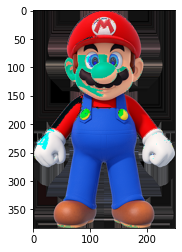

In [4]:
TARGET = image.imread('img/mario.png')
TARGET = (TARGET[..., :3] * 256).astype(np.uint8)
plt.imshow(TARGET)

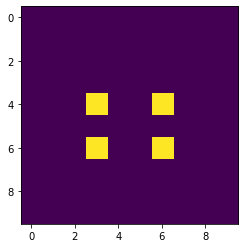

In [5]:
TARGET = np.zeros(shape=(10, 10))
TARGET[4, :] = np.array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0])
TARGET[6, :] = np.array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0])
plt.imshow(TARGET)

In [6]:
from typing import Tuple

class ImageIndividual:
    def __init__(self, shape: Tuple, genes: np.ndarray | None = None, mutate_change: float = 0.05, mutate_prob: float = 0.2):
        self.shape = shape
        self.mutate_change = mutate_change
        self.mutate_prob = mutate_prob
        if genes is None:
            self.genes = (np.random.rand(*shape)).astype(np.float32)
        else:
            self.genes = genes
        self.fitness = self.compute_fitness()

    def show(self):
        plt.imshow(self.genes)
        plt.show()

    def crossover(self, other):
        return ImageIndividual(shape=self.shape, genes=np.mean([self.genes, other.genes], axis=0))

    def mutate(self):
        if self.mutate_prob > np.random.rand():
            self.mutation = ((np.random.rand(*self.shape) * self.mutate_change) - (self.mutate_change / 2)).astype(np.float32)
            self.genes = np.clip(self.genes + self.mutation, a_min=0., a_max=1.)
            self.fitness = self.compute_fitness()

    def compute_fitness(self):
        # assert self.genes.dtype.name == 'uint8'
        assert self.genes.dtype.name == 'float32', f'genes dtype should be float32 but found {self.genes.dtype.name}.'
        return ((self.genes - TARGET)**2).sum()
    
    def copy(self):
        return ImageIndividual(shape=self.shape, genes=self.genes)

    def __repr__(self):
        return f'{self.__class__.__name__}(shape={self.shape}, fitness={self.fitness:.1f})'

ind = ImageIndividual(shape=TARGET.shape)

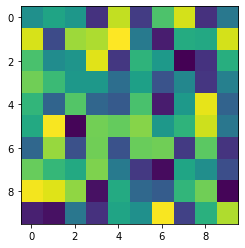

array([[ 0.018, -0.019,  0.012,  0.002, -0.013, -0.011,  0.003, -0.019,
        -0.008,  0.015],
       [ 0.018, -0.008, -0.001,  0.009,  0.002, -0.018, -0.013,  0.008,
         0.005,  0.022]], dtype=float32)

In [7]:
ind = ImageIndividual(shape=TARGET.shape, mutate_prob=1)

ind.mutate()
ind.show()
ind.mutation[:2]

In [13]:
import random
from itertools import permutations
from tqdm.auto import tqdm
from tqdm import trange
from PIL import Image
from IPython import display
from IPython.display import clear_output
from ipywidgets import Output
import seaborn as sns
import pandas as pd
from pathlib import Path
import os


class Population:
    def __init__(self, popsize: int = 20, mutation_delta: float = 0.1, mutation_prob: float = 0.1, sample_top_n = 0.1, copy_top_perc=0.02,
                 plot: bool = True, stop_threshold=0.1):
        assert 0 < popsize < 1e10, f'Popsize is probably too big, namely: {popsize}'
        assert 0 < mutation_prob < 1, f'Mutation chance should be in [0, 1].'
        assert 0 < mutation_delta < 1, f'Mutation chance should be in [0, 1].'
        assert 0 < sample_top_n < 1, f'Mutation chance should be in [0, 1].'
        assert 0 < copy_top_perc < 1, f'Mutation chance should be in [0, 1].'

        self.popsize = popsize
        self.mutation_delta = mutation_delta
        self.mutation_prob = mutation_prob
        self.sample_top_n = sample_top_n
        self.stop_threshold = stop_threshold
        self.copy_top_perc = copy_top_perc
        self.plot = plot
        self.pop = [ImageIndividual(shape=TARGET.shape, mutate_change=mutation_delta, mutate_prob=mutation_prob) for _ in range(popsize)]
        self.sort_population()

    def sort_population(self):
        self.pop = sorted(self.pop, key=lambda x: x.fitness)

    def crossover_pop(self):
        pairs = list(permutations(self.pop, r=2))
        sample_pairs = random.choices(pairs, k=self.popsize) # Sample popsize pairs out of all combinations. 
        sample_pairs += list(permutations(self.pop[:int(len(self.pop)*self.sample_top_n)], r=2))  # Sample 10% of pop out of pairs from the top 10%. 
        children = [self.pop[0].copy() for _ in range(max(int(self.copy_top_perc * len(self.pop)), 3))]  # Add 1/80 or 3 to pop, whichever is more. 
        children += [x.crossover(y) for (x, y) in sample_pairs]
        self.pop += children

    def mutate_pop(self):
        for i in self.pop:
            i.mutate()

    def optimize(self, epochs: int, gif: bool = False, plot_frequency: int = 20, name: str = 'default'):
        min_loss, avg_loss = [], []
        metrics = pd.DataFrame(columns=['min_loss', 'mean_loss'])
        output_dir = Path('img/{name}')
        img_dir = output_dir/'iters'
        os.makedirs(img_dir, exist_ok=True)
        if self.plot:
            out = Output()
            display.display(out)
            # fig, ax = plt.subplots(1, 4, figsize=(20, 5))
        max_fitness, min_fitness = 0, 10e10
        for i in (pbar:= tqdm(range(epochs))):
            self.crossover_pop()
            self.mutate_pop()
            self.sort_population()
            self.pop = self.pop[:self.popsize]
            # if i % 5 == 0:
            #     print(f'{i}. Top fitness: {self.pop[0].fitness:.1f}')
            current_best_fitness = self.pop[0].fitness
            if current_best_fitness < min_fitness: min_fitness = current_best_fitness
            if current_best_fitness > max_fitness: max_fitness = current_best_fitness
            new_metric = pd.Series({'min_loss': current_best_fitness,
                                    'mean_loss': np.mean([x.fitness for x in self.pop]),
                                    # 'epoch': i
                                    })
            metrics.loc[i] = new_metric
            
            # Logging and viz.
            pbar.set_description(f'Max: {max_fitness:.1f}, min: {min_fitness:.3f}, current: {current_best_fitness:.3f}')
            pbar.refresh()
    
            if self.plot:
                if i % plot_frequency == 0 or current_best_fitness < self.stop_threshold:
                    with out: 
                        clear_output(wait=True)
                        fig, ax = plt.subplots(1, 4, figsize=(20, 5))
                        plt.suptitle(f'Iteration {i}, Best loss: {min_fitness:.3f}')
                        ax[0].imshow(self.pop[0].genes)
                        ax[0].set_title('Current best candidate')
                        ax[1].imshow(TARGET)
                        ax[1].set_title('Target')
                        ax[2].set_title("MSE", fontsize=20)
                        ax[2].grid()
                        sns.lineplot(data=metrics, ax=ax[2])
                        ax[2].legend()
                        ax[3].set_title('Fitness distribution of population.')
                        sns.histplot(x=[x.fitness for x in self.pop], bins=10, ax=ax[3])
                        ax[3].grid()
                        ax[3].set_ylim([0, self.popsize])
                        plt.tight_layout()
                        idx = i // plot_frequency
                        plt.savefig(fname=img_dir/f'state_{idx:03d}.png', dpi=150)
                        plt.close()
            if current_best_fitness < self.stop_threshold:
                print('Early stopping criterion met. Stopping search and creating gif.')
                create_gif(src_dir=img_dir, fp_out=output_dir/'training.gif')
                break
            

    def __repr__(self):
        return f'{self.__class__.__name__}(popsize={self.popsize}, \n' + ', '.join(map(str, self.pop[:2] + self.pop[-2:])) + ')'


pop = Population(5)

## Run gridsearch experiment for suitable population and individual parameters

In [ ]:
from typing import Dict, Any
from joblib import Parallel, delayed
from itertools import product
import pandas as pd
import plotly.express as px

mutation_delta = [0.1, 0.2, 0.3, 0.4]
mutation_prob = [0.1, 0.3, 0.5]
copy_top_perc = [0.02, 0.04, 0.08]
sample_top_n = [0.1, 0.2, 0.05]
results = []

def optimize_with_config(mutation_delta, mutation_prob, copy_top_perc, sample_top_n) -> Dict[str, Any]:
    pop = Population(popsize=20, mutation_delta=mutation_delta, mutation_prob=mutation_prob, copy_top_perc=copy_top_perc, sample_top_n=sample_top_n, plot=False)
    pop.optimize(epochs=400)
    return {
        'mutation_delta': mutation_delta, 
        'mutation_prob': mutation_prob, 
        'copy_top_perc': copy_top_perc, 
        'sample_top_n': sample_top_n, 
        'best_fitness': pop.pop[0].fitness
        }

In [ ]:
param_combinations = list(product(mutation_delta, mutation_prob, copy_top_perc, sample_top_n))
result = Parallel(n_jobs=-1)(delayed(optimize_with_config)(mdelta, mprob, topp, topn) for mdelta, mprob, topp, topn in tqdm(param_combinations, total=len(param_combinations)))
results_df = pd.DataFrame(result)
results_df.to_parquet('grid_search_results.parquet')
results_df.head()

  0%|          | 0/108 [00:00<?, ?it/s]

Max: 3306770688.0, min: 3306377216.0, current: 3306377216.0: 100%|██████████| 400/400 [02:37<00:00,  2.54it/s]
Max: 3306796032.0, min: 3306394624.0, current: 3306394624.0: 100%|██████████| 400/400 [02:38<00:00,  2.53it/s]
Max: 3306786304.0, min: 3306388480.0, current: 3306388480.0: 100%|██████████| 400/400 [02:38<00:00,  2.53it/s]
Max: 3306811392.0, min: 3306387712.0, current: 3306387712.0: 100%|██████████| 400/400 [02:39<00:00,  2.50it/s]
Max: 3306772992.0, min: 3306351104.0, current: 3306351104.0: 100%|██████████| 400/400 [02:49<00:00,  2.36it/s]
Max: 3306776576.0, min: 3306366976.0, current: 3306366976.0: 100%|██████████| 400/400 [02:49<00:00,  2.36it/s]
Max: 3306749184.0, min: 3306306816.0, current: 3306306816.0: 100%|██████████| 400/400 [02:49<00:00,  2.35it/s]
Max: 3306765312.0, min: 3306360832.0, current: 3306360832.0: 100%|██████████| 400/400 [02:50<00:00,  2.35it/s]
Max: 3306756096.0, min: 3306243072.0, current: 3306243072.0: 100%|██████████| 400/400 [03:46<00:00,  1.77it/s]
M

[]

In [ ]:
results_df = pd.read_parquet('grid_search_results.parquet')
results_df.sort_values('best_fitness')

,mutation_delta,mutation_prob,copy_top_perc,sample_top_n,best_fitness
64,0.3,0.3,0.02,0.20,3.306214e+09
22,0.1,0.5,0.04,0.20,3.306222e+09
73,0.3,0.5,0.02,0.20,3.306229e+09
76,0.3,0.5,0.04,0.20,3.306229e+09
1,0.1,0.1,0.02,0.20,3.306235e+09
...,...,...,...,...,...
80,0.3,0.5,0.08,0.05,3.306404e+09
92,0.4,0.3,0.02,0.05,3.306412e+09
47,0.2,0.5,0.02,0.05,3.306414e+09
29,0.2,0.1,0.02,0.05,3.306415e+09


In [ ]:
px.parallel_coordinates(results_df, color='best_fitness', labels=['mutation_delta', 'mutation_prob', 'copy_top_perc', 'sample_top_n', 'best_fitness'])

## Run full optimization 

In [14]:
pop = Population(popsize=200, mutation_delta=0.15, mutation_prob=0.4, copy_top_perc=0.04, sample_top_n=0.2)
pop.optimize(epochs=200, plot_frequency=2)

Output()

  0%|          | 0/200 [00:00<?, ?it/s]

Early stopping criterion met. Stopping search and creating gif.
Image saved at /Users/baukebrenninkmeijer/Projects/simple-genetic-algorithm/img/4dots/training.gif.


![training gif](img/4dots/training.gif)